In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import norm
from scipy.stats import ttest_1samp
import warnings
warnings.filterwarnings("ignore", message="Glyph .* missing from current font.")

# 读取excel文件并获取指定列, 这里以这三个列作为示例
df = pd.read_csv('Data\order_detail.csv', usecols=['order_id', 'amount', 'brand_code'])

# 将列的数值赋值给数组array_X
array_amount = df['amount'].values
array_brand_code = df['brand_code'].values

#print(array_amount)
#print(array_brand_code)

<>:11: SyntaxWarning: invalid escape sequence '\o'
<>:11: SyntaxWarning: invalid escape sequence '\o'
C:\Users\admin\AppData\Local\Temp\ipykernel_22548\3383146347.py:11: SyntaxWarning: invalid escape sequence '\o'
  df = pd.read_csv('Data\order_detail.csv', usecols=['order_id', 'amount', 'brand_code'])


In [27]:
# 对数组从大到小排序
sorted_amount = np.sort(array_amount)[::-1]

# 取出，并剔除最大值
max_value = sorted_amount[0]
sorted_amount_without_Max = sorted_amount[1:]

print("Max Value: ", max_value)
print("Sorted array: ", sorted_amount_without_Max)

Max Value:  288630.0
Sorted array:  [286489.  206483.1  62100.  ...      0.       0.       0. ]


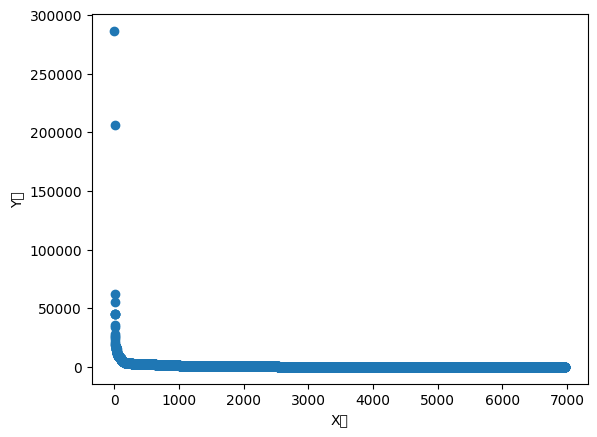

In [28]:
# 定义一个幂律函数，来拟合这组排序过来后数据

# 定义b值为负的幂律函数
def power_law(x, a, b):
    return a * np.power(x, -b)

# 生成x,y数据， x是以自然排序生成的，从第2位开始，因为我们要留第1位来预测
# array = np.arange(start, stop, step)
start_no = 2
xdata = np.arange(start_no, len(sorted_amount_without_Max)+start_no, 1)
ydata = sorted_amount_without_Max


# 尝试画出其分布图
plt.scatter(xdata, ydata)
plt.xlabel('X轴')
plt.ylabel('Y轴')
plt.show()


拟合参数 a = 582480.44801794, b = 1.1410182878860646


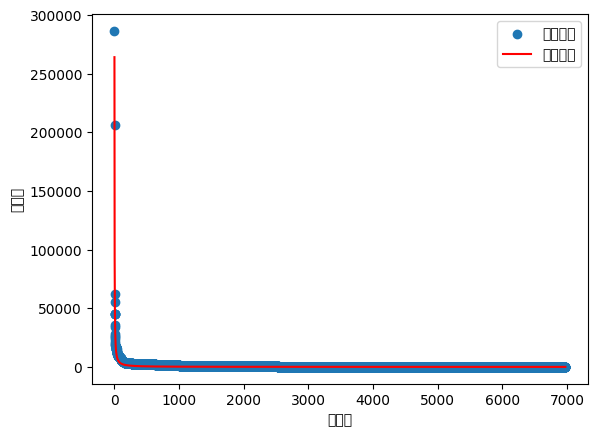

In [29]:
# 使用curve_fit进行拟合
popt, pcov = curve_fit(power_law, xdata, ydata)

# 输出拟合参数
print("拟合参数 a = {}, b = {}".format(popt[0], popt[1]))

# 绘制原始数据 和 用红色绘制拟合曲线
plt.scatter(xdata, ydata, label='原始数据')
plt.plot(xdata, power_law(xdata, *popt), 'r-', label='拟合曲线')
plt.xlabel('自变量')
plt.ylabel('因变量')
plt.legend()
plt.show()

In [30]:
# 按幂律函数推出第一名的值，和第一名做对比
start_index = 1
max_predict = popt[0] * np.power(start_index, -popt[1])
print("max_predict:",max_predict)
print("max_now:",max_value)

max_predict: 582480.44801794
max_now: 288630.0


sorted_amount_predict： [2.64119594e+05 1.66294266e+05 1.19762235e+05 ... 2.39889576e+01
 2.39850317e+01 2.39811070e+01]
sorted_diff_array:  [  30741.85185444   20087.77501181   18422.50057457 ...  -24510.40550309
  -86720.86517377 -120194.73386253]


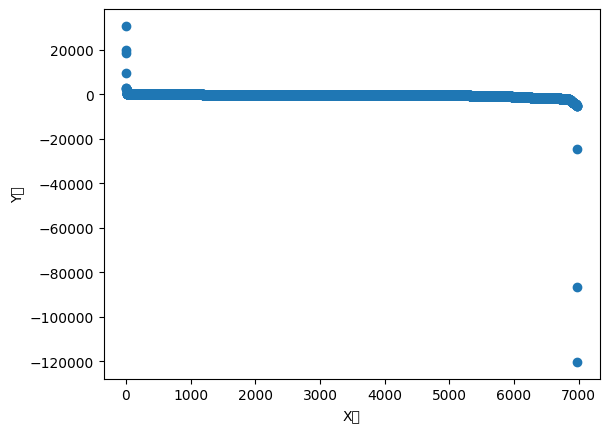

In [31]:
# 基于拟合的幂律函数， 生成预测数组 
x = np.arange(start_no, len(sorted_amount)+start_no, 1)
sorted_amount_predict = popt[0] * np.power(x, -popt[1])
print("sorted_amount_predict：",sorted_amount_predict)

# 计算预测数组与实际数组的残差值
diff_array = sorted_amount_predict - sorted_amount

#残差值排序：从大到小
sorted_diff_array = np.sort(diff_array)[::-1]
print("sorted_diff_array: ", sorted_diff_array)

# 尝试画出【残差值】的分布图
plt.scatter(x, sorted_diff_array)
plt.xlabel('X轴')
plt.ylabel('Y轴')
plt.show()


mean均值为: -475.1845835524175
std标准差为: 1978.040079487235


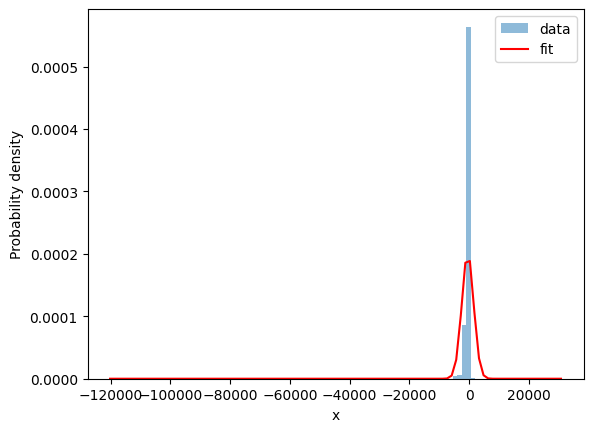

In [32]:
# 基于残差值数组，来拟合高斯模型。（我们假设残差值总是符合高斯模型的）
mean, std = norm.fit(sorted_diff_array)
print("mean均值为:",mean)
print("std标准差为:",std)

# 用拟合结果生成高斯分布曲线 
# 概率密度函数（PDF）
x = np.linspace(sorted_diff_array.min(), sorted_diff_array.max(), 100)
y = norm.pdf(x, mean, std)

# 绘制原始数据和高斯分布曲线， 用100柱的直方图来显示
plt.hist(sorted_diff_array, bins=100, density=True, alpha=0.5, label='data')
plt.plot(x, y, 'r-', label='fit')
plt.xlabel('x')
plt.ylabel('Probability density')
plt.legend()
plt.show()

In [49]:
# 计算 给定值X和给定数据数组之间的显著性

# 预测值与实际值的差值
diff_max = max_predict - max_value

# 计算z-score， Z-Score标准化是数据处理的一种常用方法。通过它能够将不同量级的数据转化为统一量度的Z-Score分值进行比较。
z = (diff_max - mean) / std

# norm.cdf()函数可以用来计算z-score对应的概率值（CDF），因为z-score遵循标准正态分布（均值为0，标准差为1）
p_value = 2 * (1 - norm.cdf(abs(z)))

print("双尾p值:", p_value)

if p_value < 0.05:
    print(f"***【幂律分布与不平凡的最大值检测】：我们对最大值的预测为{max_predict}，但实际为{max_value}，这种可能性为{p_value}，我们可以确定这个最大值是异常值，或者幂律分布不足以说明该列数据的特点***")
else:
    print(f"***【幂律分布与不平凡的最大值检测】：我们对最大值的预测为{max_predict}，但实际为{max_value}，这种可能性为{p_value}，这种可能性在统计学上是可能出现的。所以我们认为该列数据符合幂律分布***")


双尾p值: 0.0
***【幂律分布与不平凡的最大值检测】：我们对最大值的预测为582480.44801794，但实际为288630.0，这种可能性为0.0，我们可以确定这个最大值是异常值，或者幂律分布不足以说明该列数据的特点***
